# YOLOv8-CustomData-Detection-Pipeline

---

## Overview
本ノートブックでは、カスタムデータセット（自作データセット）に対して[YOLOv8](https://github.com/ultralytics/ultralytics)を使用し、学習から推論、そして精度評価までの一連の流れを取り扱います。本ノートブックの主要な目的はパイプラインの構築に焦点を当てることであり、精度向上の手法や詳細には触れておりません。

## Setup

In [1]:
!nvidia-smi

Mon Oct  9 10:48:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    26W /  70W |   1527MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
cd ../yolov8

/app/object_detection/yolov8


## Preparation
以下を準備します。<br>


*   Dataset
  *   image_scraping -> auto_annotaion -> data_augmentationのノートブックを順に実行することで準備が完了

*   yamlファイル


### yamlファイル
以下のようなyamlファイルをyolov8配下に配置します。<br>
学習実行時にFileNotFoundErrorが出る場合は、yamlファイルに絶対パスを記載してください。<br>

In [3]:
ls

data.yaml  dataset/


In [4]:
!cat data.yaml

# class names
names: ['car']
# number of classes
nc: 1

# dataset path
train: /app/object_detection/yolov8/dataset/car/train/images
val: /app/object_detection/yolov8/dataset/car/valid/images
test: /app/object_detection/yolov8/dataset/car/test/images

## Models
以下のリンクからお好きな学習モデルをダウンロードして使用することができます。<br>
[参考](https://github.com/ultralytics/ultralytics/tree/main#models)<br>


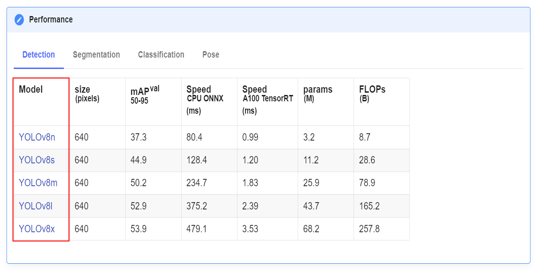

## Train
以下のオプションを設定することができます。<br>
デフォルト値は以下のファイルに記載されております。<br>
[参考](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml#L7)<br>


*   data: データセットの情報が記載されているyamlファイルのパス

*   model: モデルのパス
*   epochs: エポック数
*   imgsz: 入力する画像サイズ
*   device: 実行デバイス
*   batch: バッチサイズ
*   name: 実験名（/runs/detect配下に、指定した名称のフォルダに結果が格納されます。）



In [5]:
!yolo detect train data=data.yaml model=yolov8n.pt epochs=20 imgsz=416 device=0 batch=8 name=car

100%|███████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 273MB/s]
Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 14927MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=20, patience=50, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=car, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

## Test
以下のオプションを設定することができます。<br>
デフォルト値は以下のファイルに記載されております。<br>
[参考](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml#L42)

*   model: モデルのパス（学習した重みのパス）

*   data: データセットの情報が記載されているyamlファイルのパス
*   split: 検証に使用するデータセットの選択（testデータで評価したい場合、split=testを指定する。）
*   conf: 信頼度の閾値（デフォルトは0.001）
*   iou: NMSを実行する際のIoUに閾値（この設定により、NMSの過程でどの程度のオーバーラップを許容するかを制御することができます。デフォルトは0.7）


In [6]:
!yolo detect val model="/app/object_detection/yolov8/runs/detect/car/weights/best.pt" data=data.yaml split=test conf=0 iou=0.45

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 14927MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /app/object_detection/yolov8/dataset/car/test/labels... 38 images,
val: New cache created: /app/object_detection/yolov8/dataset/car/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         38         69      0.986      0.928      0.971      0.812
Speed: 1.9ms preprocess, 23.6ms inference, 0.0ms loss, 10.0ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Visualization
学習の結果は、/runs/detect/val配下に格納されます。<br>
PrecisionやRecallといった評価指標の学習曲線を確認することで、モデルの学習の進行状況や収束具合を把握できます。<br>
さらに、Objectの検出具合の画像を視覚的に確認することで、モデルの予測精度や誤検出の傾向も理解することができます。<br>

In [7]:
!ls runs/detect/val

F1_curve.png  confusion_matrix.png	       val_batch1_labels.jpg
PR_curve.png  confusion_matrix_normalized.png  val_batch1_pred.jpg
P_curve.png   val_batch0_labels.jpg	       val_batch2_labels.jpg
R_curve.png   val_batch0_pred.jpg	       val_batch2_pred.jpg


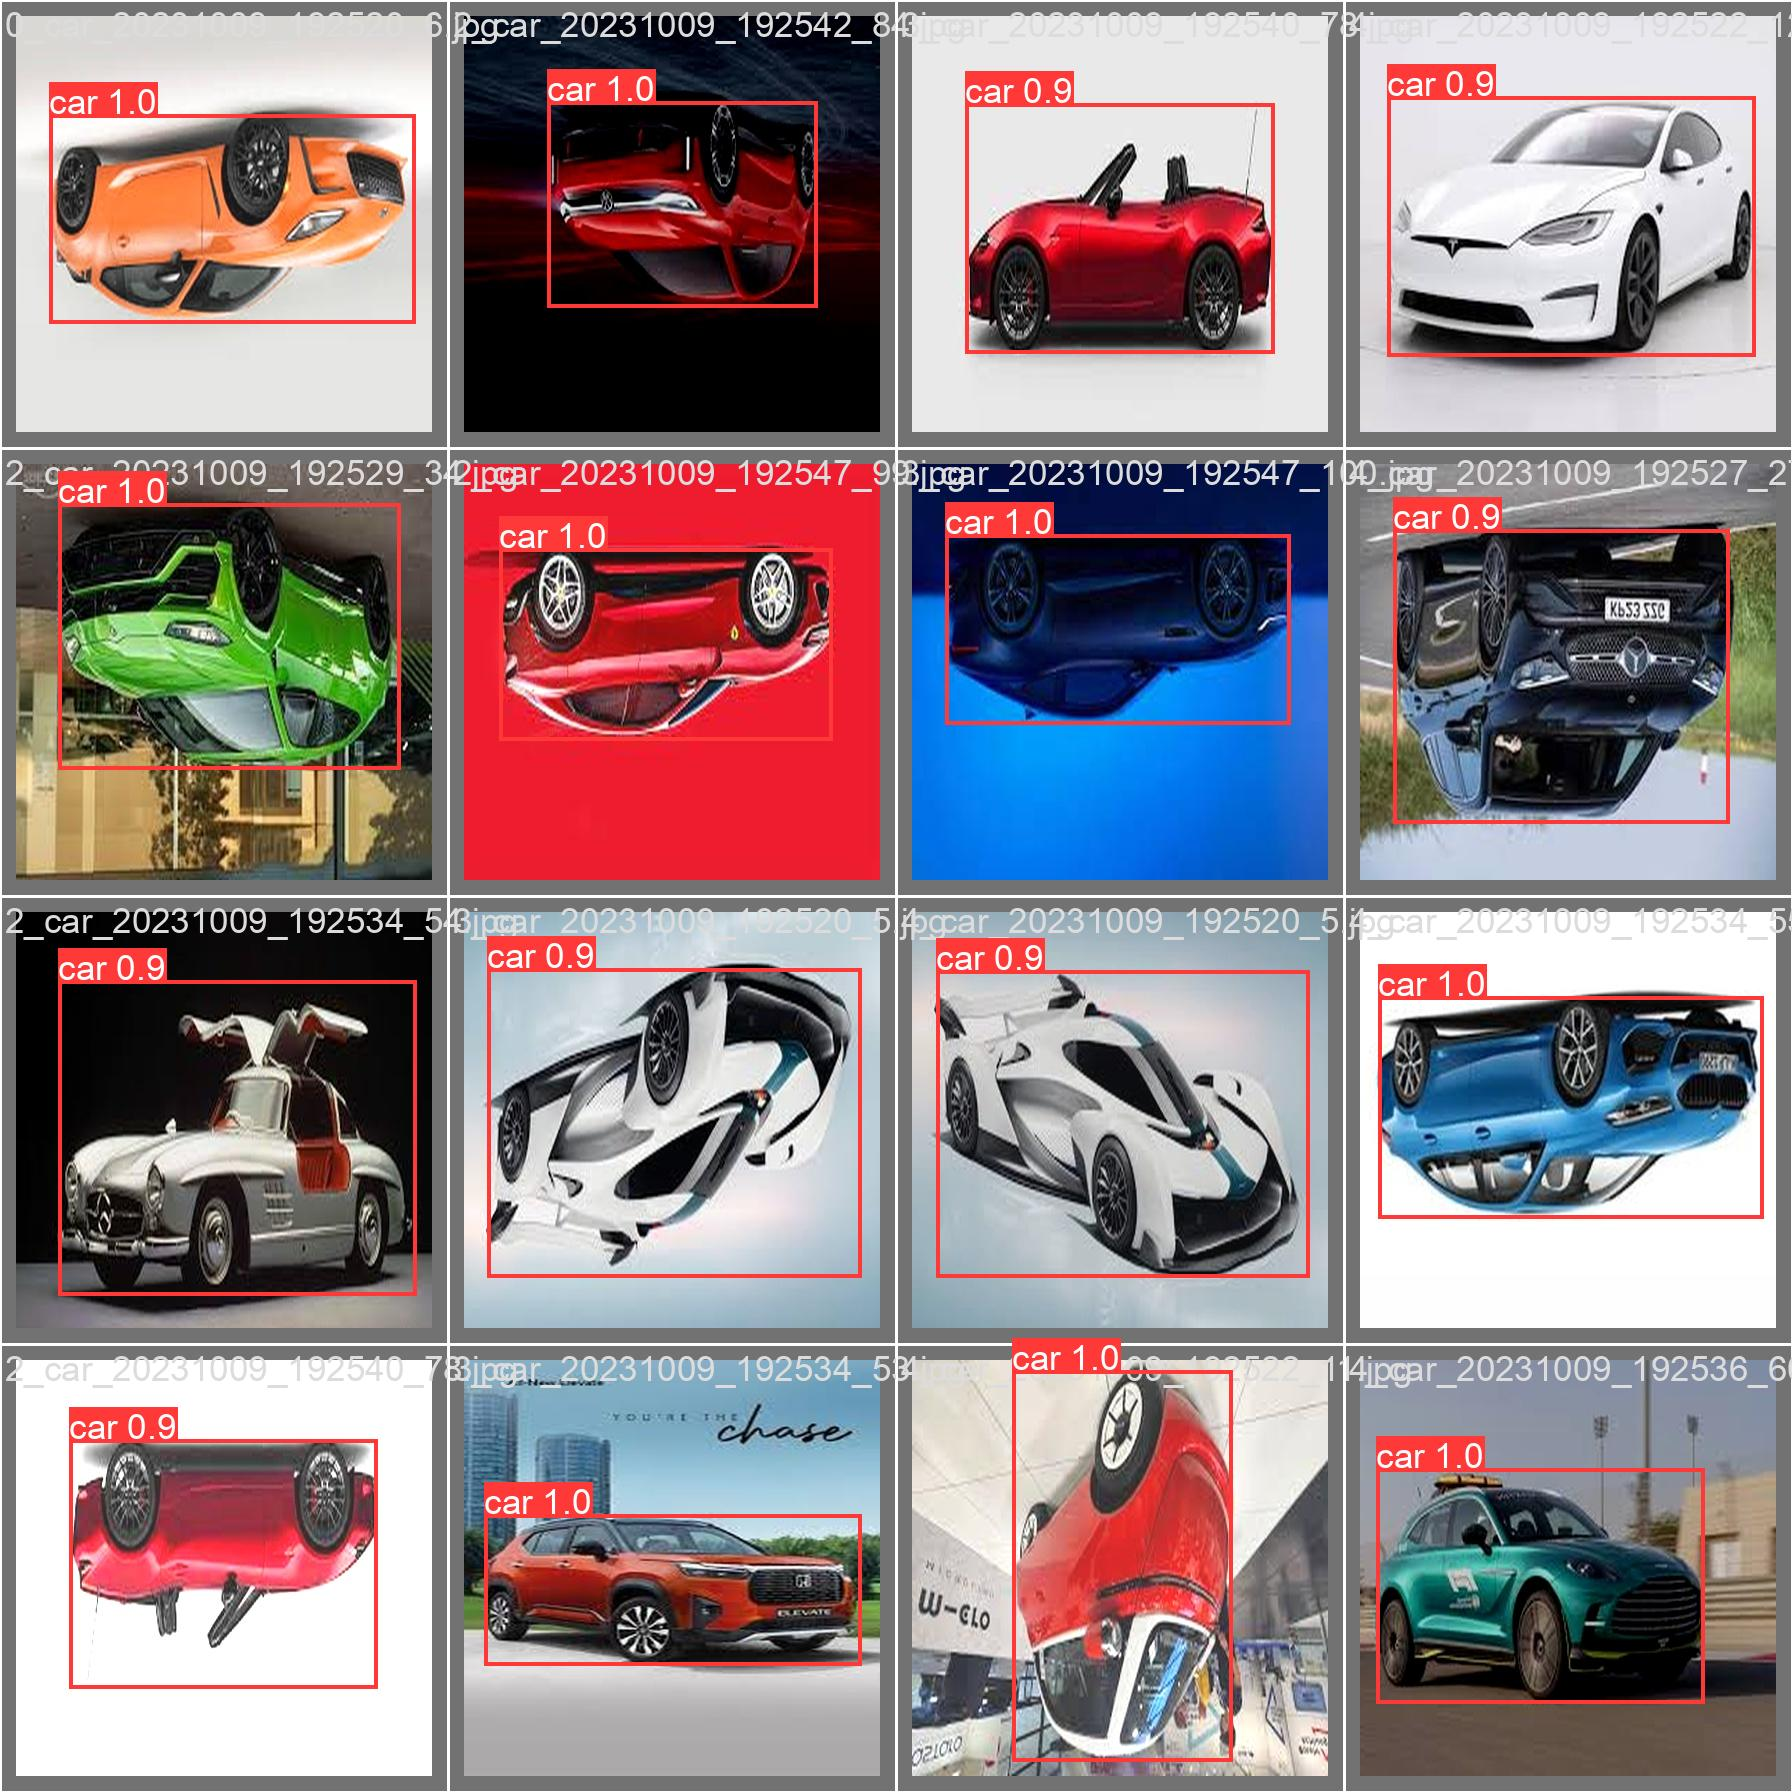

In [8]:
from PIL import Image
from IPython.display import Image, clear_output

# 学習結果の可視化
Image(filename='runs/detect/val/val_batch0_labels.jpg', width=800)
Image(filename='runs/detect/val/val_batch0_pred.jpg', width=800)

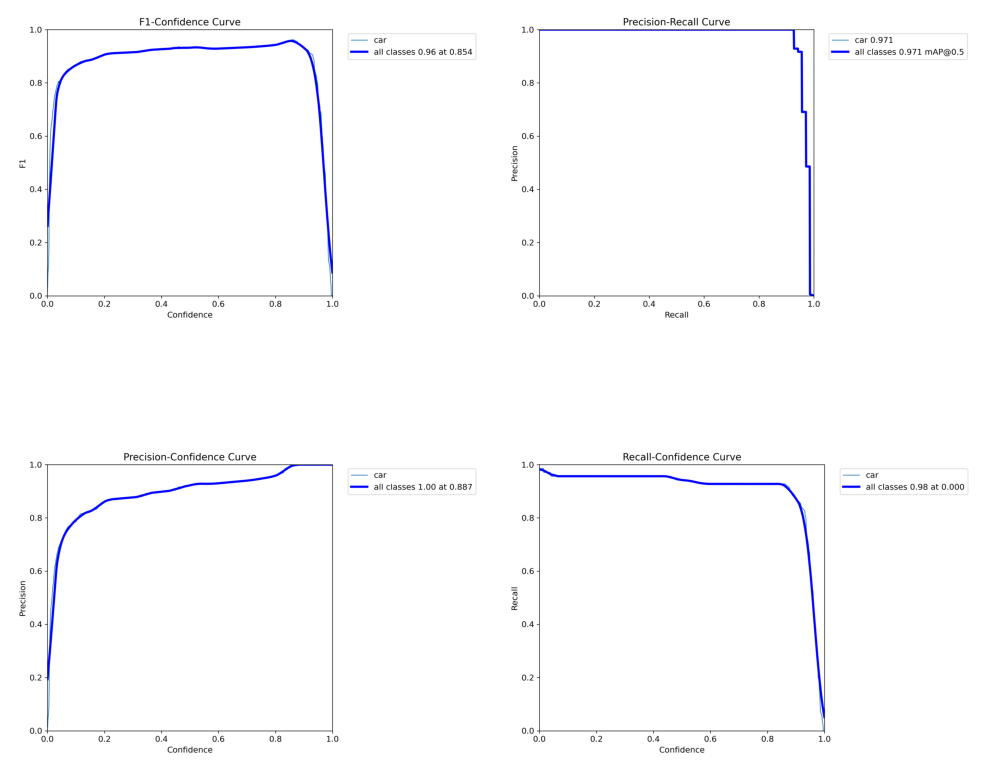

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

image_files = [
    'runs/detect/val/F1_curve.png',
    'runs/detect/val/PR_curve.png',
    'runs/detect/val/P_curve.png',
    'runs/detect/val/R_curve.png'
]

# 2x2のグリッドでサブプロットを作成
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 各サブプロットに画像を表示
for ax, image_file in zip(axes.ravel(), image_files):
    img = Image.open(image_file)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Predict
以下のオプションを設定することができます。<br>
デフォルト値は以下のファイルに記載されております。<br>
[参考](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml#L54)


*   model: モデルのパス（学習した重みのパス）

*   source: 画像や動画が格納されているフォルダのパス
*   conf: 信頼度の閾値（デフォルトは0.25）
*   iou: NMSを実行する際のIoUに閾値（この設定により、NMSの過程でどの程度のオーバーラップを許容するかを制御することができます。デフォルトは0.7）
*   imgsz: 入力する画像サイズ



In [10]:
!yolo detect predict model="/app/object_detection/yolov8/runs/detect/car/weights/best.pt" source="/app/image_scraping/save_images/LEXUS" conf=0.25 iou=0.45 imgsz=416

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 14927MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195457_1.jpg: 416x416 1 car, 5.6ms
image 2/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195458_2.jpg: 416x416 1 car, 5.6ms
image 3/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195458_3.jpg: 416x416 2 cars, 5.6ms
image 4/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195458_4.jpg: 416x416 1 car, 5.6ms
image 5/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195458_5.jpg: 416x416 1 car, 5.6ms
image 6/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195459_10.jpg: 416x416 2 cars, 5.7ms
image 7/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195459_6.jpg: 416x416 1 car, 5.6ms
image 8/100 /app/image_scraping/save_images/LEXUS/LEXUS_20231009_195459_7.jpg: 416x416 1 car, 5.6ms
image 9/100 /app/image_scrapi

## Prediction Results
以下のような推論結果を取得することができました。

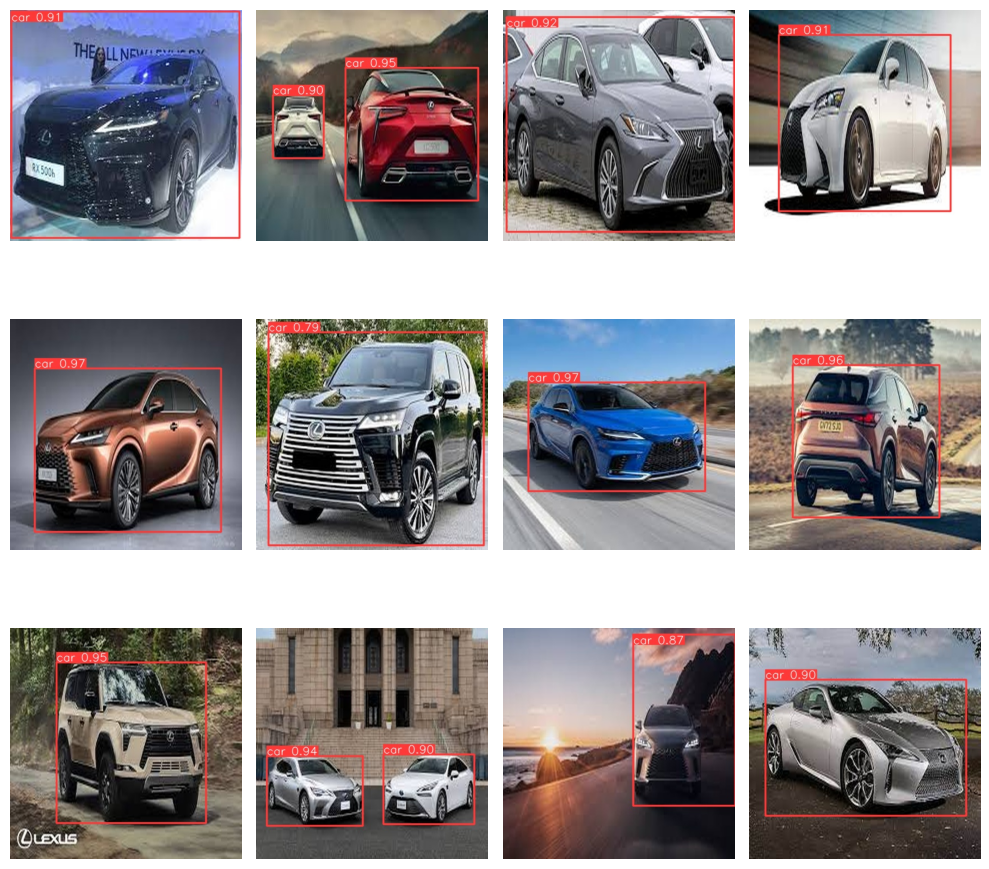

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# パラメータ設定
folder_path = "runs/detect/predict"
grid_size = (3, 4)
image_size = (10, 10)

# フォルダ内の画像のリストを取得
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))]
image_files = image_files[:grid_size[0] * grid_size[1]]

fig, axes = plt.subplots(*grid_size, figsize=image_size)

for ax, img_path in zip(axes.ravel(), image_files):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()